# Scenario 1: Ecological Shifts

In our model, we use the `Redfield Ratio' to link the uptake and release of phosphorous (P) and carbon (DIC) by marine organisms. So far, we've used a C:P value of 106:1, which is a good representative number for average ocean biomass. However, this ratio can vary as a function of ecology, with observed values between 75-250. The C:P ratio of marine life could change as marine ecology responds to future climate change. In this question, you will consider the impact of systematic shifts in C:P ratios on carbon in the ocean and atmosphere.

First, we must add a mechanism to simulate these ecological shifts in the model. It is possible to do this by parameterising the change in C:P ratio as a function of the atmospheric $\mathrm{pCO_2}$ in the model:

$$
P_{Redfield} = 106 + \beta \left( \frac{\mathrm{pCO_2}}{\mathrm{pCO_{2(ref)}}} - 1 \right)
$$

Where $\mathrm{pCO_{2(ref)}}$ is the steady state $\mathrm{pCO_2}$ of your original model, and $\beta$ describes the change in biomass C:P ratio per doubling in $\mathrm{pCO_2}$.

Include the sensitivity of biomass C:P ratio to $\mathrm{pCO_2}$ in your model, and address the following questions:

1. Set the $\beta$ value to 20. Conduct a $\mathrm{CO_2}$ release experiment, where $\mathrm{8~GtC~yr^{-1}}$ is emitted into the atmosphere for 200 years (between model years 400-600). Run the model to steady-state, and examine the evolution of the carbon chemistry of the surface ocean and atmosphere compared to the original model. Discuss the patterns you observe.
2. Repeat this experiment with a $\beta$ value of -20. How does this alter the patterns you observed in the previous experiment? Discuss the mechanisms behind the changes you observe.
3. Ecological shifts are unlikely to be global. Studies have suggested that we might expect to see an increase in the C:P ratios in the high latitudes, but a decrease in the low latitudes. Repeat the same $\mathrm{CO_2}$ release experiment with $\beta = 10$ in the high latitudes, and $\beta = -10$ in the low latitudes. Discuss the patterns you observe in context of the impact of ecology on ocean carbon storage.
4. How realistic is your simulation? What additional factors might influence how these patterns manifest in the real ocean?


## Model Set-Up

In [1]:
# This code installs some required packages for the rest of the notebook. Run this once at the start - it should take <30 seconds to run.
%%capture
import os
if not os.path.exists('./OceanTools'):
    !git clone https://github.com/Quantitative-Environmental-Science/OceanTools.git

import sys
sys.path.append('./OceanTools')

!pip install cbsyst

import numpy as np
import matplotlib.pyplot as plt
from cbsyst import Csys  # this is for carbon chemistry calculations

In [2]:
# global variables
V_ocean = 1.34e18  # volume of the ocean in m3
SA_ocean = 358e12  # surface area of the ocean in m2
fSA_hilat = 0.15  # fraction of ocean surface area in 'high latitude' box

# variables used to calculate Q
Q_alpha = 1e-4
Q_beta = 7e-4
Q_k = 8.3e17

# salinity balance - the total amount of salt added or removed to the surface boxes
Fw = 0.1  # low latitude evaporation - precipitation in units of m yr-1
Sref = 35  # reference salinity in units of g kg-1
E = Fw * SA_ocean * (1 - fSA_hilat) * Sref  # amount of salt removed from the low latitude box,  g kg-1 yr-1, ~ kg m-3 yr-1

In [3]:
# NOTE: Initial DIC, TA, PO4 and pCO2 values are set to steady state values from the unmodified model.

init_hilat = {
    'name': 'hilat',
    'depth': 200,  # box depth, m
    'SA': SA_ocean * fSA_hilat,  # box surface area, m2
    'T': 3.897678,  # initial water temperature, Celcius
    'S': 34.37786,  # initial salinity
    'T_atmos': 0.,  # air temperature, Celcius
    'tau_M': 100.,  # timescale of surface-deep mixing, yr
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': -E,  # salt added due to evaporation - precipitation, kg m-3 yr-1
    'tau_CO2': 2.,  # timescale of CO2 exchange, yr
    'DIC': 2.02837,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': 2.22116,  # Total Alkalinity, mol m-3
    'tau_PO4': 3.,  # phosphate half life, yr at initial f_CaCO3
    'PO4': 8.8995e-5,  # Phosphate conc, mol m-3
    'f_CaCO3': 0.2,  # fraction of organic matter export that produces CaCO3 at starting [CO3]
    'beta_redfield': 20, # adding redfield constant
    'redfield': 106, # adding redifeld ratio
    'pCO2_ref': 265.96,  # reference pCO2 level, taken from steady state of original model
}
init_hilat['V'] = init_hilat['SA'] *  init_hilat['depth']  # box volume, m3

init_lolat = {
    'name': 'lolat',
    'depth': 100,  # box depth, m
    'SA': SA_ocean * (1 - fSA_hilat),  # box surface area, m2
    'T': 23.60040,  # initial water temperature, Celcius
    'S': 35.37898,  # initial salinity
    'T_atmos': 25.,  # air temperature, Celcius
    'tau_M': 250.,  # timescale of surface-deep mixing, yr
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': E,  # salinity balance, PSU m3 yr-1
    'tau_CO2': 2.,  # timescale of CO2 exchange, yr
    'DIC': 1.99405,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': 2.21883,  # Total Alkalinity, mol m-3
    'tau_PO4': 2.,  # phosphate half life, yr at initial f_CaCO3
    'PO4': 1.6541e-4,  # Phosphate conc, mol m-3
    'f_CaCO3': 0.3,  # fraction of organic matter export that produces CaCO3 at starting [CO3]
    'beta_redfield': 20, # adding redfield constant
    'redfield': 106, # adding redifeld ratio
    'pCO2_ref': 520.01,  # reference pCO2 level (from SS of original)
}
init_lolat['V'] = init_lolat['SA'] *  init_lolat['depth']  # box volume, m3

init_deep = {
    'name': 'deep',
    'V': V_ocean - init_lolat['V'] - init_hilat['V'],  # box volume, m3
    'T': 5.483637,  # initial water temperature, Celcius
    'S': 34.47283,  # initial salinity
    'DIC': 2.32712,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': 2.31640,  # Total Alkalinity, mol m-3
    'PO4': 2.30515e-3,  # Phosphate conc, mol m-3
}

init_atmos = {
    'name': 'atmos',
    'mass': 5.132e18,  # kg
    'moles_air': 1.736e20,  # moles
    'moles_CO2': 872e15 / 12,  # moles
    'GtC_emissions': 0.0  # annual emissions of CO2 into the atmosphere, GtC
}
init_atmos['pCO2'] = init_atmos['moles_CO2'] / init_atmos['moles_air'] * 1e6

### Original Model Code

The function below contains the full code for the model you have developed in the last three practicals. This should be the 'baseline' model that you will use as a comparison point for your new model.

In [25]:
def ocean_model(lolat, hilat, deep, atmos, tmax, dt):

    # create the time scale for the model
    time = np.arange(0, tmax + dt, dt)

    # identify which variables will change with time
    model_vars = ['T', 'S', 'DIC', 'TA', 'PO4']
    atmos_model_vars = ['moles_CO2', 'pCO2']

    # create copies of the input dictionaries so we don't modify the originals
    lolat = lolat.copy()
    hilat = hilat.copy()
    deep = deep.copy()
    atmos = atmos.copy()

    # turn all time-evolving variables into arrays containing the start values
    for box in [lolat, hilat, deep]:
        for k in model_vars:
            box[k] = np.full(time.shape, box[k])
    for k in atmos_model_vars:
        atmos[k] = np.full(time.shape, atmos[k])
    if isinstance(atmos['GtC_emissions'], (int, float)):
        atmos['GtC_emissions'] = np.full(time.shape, atmos['GtC_emissions'])

    # calculate initial surface carbon chemistry in the surface boxes using Csys, and store a few key variables - CO2, pH, pCO2 and K0
    for box in [lolat, hilat]:
        csys = Csys(
            TA=box['TA'],
            DIC=box['DIC'],
            T_in=box['T'], S_in=box['S'],
            unit='mmol'
            )
        box['CO2'] = csys.CO2
        box['pH'] = csys.pHtot
        box['pCO2'] = csys.pCO2
        box['K0'] = csys.Ks.K0

    # Create a dictionary to keep track of the fluxes calculated at each step
    fluxes = {}

    for i in range(1, time.size):
        last = i - 1  # index of last model step

        # calculate circulation flux, Q
        dT = lolat['T'][last] - hilat['T'][last]
        dS = lolat['S'][last] - hilat['S'][last]
        Q = Q_k * (Q_alpha * dT - Q_beta * dS)

        # calculate mixing fluxes for model variables
        for var in model_vars:
            fluxes[f'Q_{var}_deep'] = Q * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_hilat'] = Q * (lolat[var][last] - hilat[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_lolat'] = Q * (deep[var][last] - lolat[var][last]) * dt  # mol dt-1

            fluxes[f'vmix_{var}_hilat'] = hilat['V'] / hilat['tau_M'] * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'vmix_{var}_lolat'] = lolat['V'] / lolat['tau_M'] * (lolat[var][last] - deep[var][last]) * dt  # mol dt-1

        # calculate surface-specific fluxes
        for box in [hilat, lolat]:
            boxname = box['name']
            # temperature exchange with atmosphere
            fluxes[f'dT_{boxname}'] = box['V'] / box['tau_T'] * (box['T_atmos'] - box['T'][last]) * dt  # mol dt-1
            # CO2 exchange with atmosphere
            fluxes[f'dCO2_{boxname}'] = box['V'] / box['tau_CO2'] * (box['CO2'][last] - 1e-3 * atmos['pCO2'][last] * box['K0'][last]) * dt  # mol dt-1
            # organic matter production
            fluxes[f'export_PO4_{boxname}'] = box['PO4'][last] * box['V'] / box['tau_PO4'] * dt  # mol PO4 dt-1
            # DIC export by productivity :                                  redfield + calcification
            fluxes[f'export_DIC_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (106 + 106 * box['f_CaCO3'])  # mol DIC dt-1
            # TA export by productivity :                                  redfield + calcification
            fluxes[f'export_TA_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (-18 + 2 * 106 * box['f_CaCO3'])  # mol TA dt-1

        fluxes['dCO2_emissions'] = atmos['GtC_emissions'][last] * 1e15 / 12 * dt  # mol dt-1

        # update deep box
        for var in model_vars:
            if var in ['T', 'S']:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat']
                ) / deep['V']
            else:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat'] + fluxes[f'export_{var}_hilat'] + fluxes[f'export_{var}_lolat']
                ) / deep['V']

        # update surface boxes
        for box in [hilat, lolat]:
            boxname = box['name']
            box['S'][i] = box['S'][last] + (fluxes[f'Q_S_{boxname}'] - fluxes[f'vmix_S_{boxname}'] + box['E'] * dt) / box['V']
            box['T'][i] = box['T'][last] + (fluxes[f'Q_T_{boxname}'] - fluxes[f'vmix_T_{boxname}'] + fluxes[f'dT_{boxname}']) / box['V']

            box['DIC'][i] = box['DIC'][last] + (fluxes[f'Q_DIC_{boxname}'] - fluxes[f'vmix_DIC_{boxname}'] - fluxes[f'dCO2_{boxname}'] - fluxes[f'export_DIC_{boxname}']) / box['V']
            box['TA'][i] = box['TA'][last] + (fluxes[f'Q_TA_{boxname}'] - fluxes[f'vmix_TA_{boxname}'] - fluxes[f'export_TA_{boxname}']) / box['V']
            box['PO4'][i] = box['PO4'][last] + (fluxes[f'Q_PO4_{boxname}'] - fluxes[f'vmix_PO4_{boxname}'] - fluxes[f'export_PO4_{boxname}']) / box['V']

            # update carbon speciation
            csys = Csys(
                TA=box['TA'][i],
                DIC=box['DIC'][i],
                T_in=box['T'][i], S_in=box['S'][i],
                unit='mmol'
                )
            box['CO2'][i] = csys.CO2[0]
            box['pH'][i] = csys.pHtot[0]
            box['pCO2'][i] = csys.pCO2[0]
            box['K0'][i] = csys.Ks.K0

        # update atmosphere
        atmos['moles_CO2'][i] = atmos['moles_CO2'][last] + fluxes['dCO2_hilat'] + fluxes['dCO2_lolat'] + fluxes['dCO2_emissions']
        atmos['pCO2'][i] = 1e6 * atmos['moles_CO2'][i] / atmos['moles_air']

    return time, lolat, hilat, deep, atmos

lolat: 520.05
hilat: 265.97
atmos: 418.08
lolat: 532.19
hilat: 269.40
atmos: 426.74


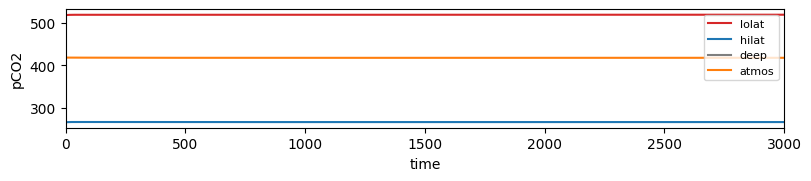

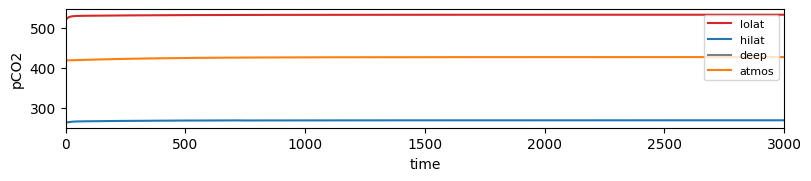

In [26]:
# perform baseline model run
time, ololat, ohilat, odeep, oatmos = ocean_model(init_lolat, init_hilat, init_deep, init_atmos, 3000, 1)
time, lolat, hilat, deep, atmos = new_ocean_model(init_lolat, init_hilat, init_deep, init_atmos, 3000, 1)

from tools import plot
from tools.helpers import get_last_values

plot.boxes(time, ['pCO2'], ololat, ohilat, odeep, oatmos)
plot.boxes(time, ['pCO2'], lolat, hilat, deep, atmos)

for k, v in get_last_values(ololat, ohilat, oatmos).items():
    print(f"{k}: {v['pCO2']:.2f}")
for k, v in get_last_values(lolat, hilat, atmos).items():
    print(f"{k}: {v['pCO2']:.2f}")

### Modify the Model Below

In [24]:
def new_ocean_model(lolat, hilat, deep, atmos, tmax, dt):

    # create the time scale for the model
    time = np.arange(0, tmax + dt, dt)

    # identify which variables will change with time
    model_vars = ['T', 'S', 'DIC', 'TA', 'PO4']
    atmos_model_vars = ['moles_CO2', 'pCO2']

    # create copies of the input dictionaries so we don't modify the originals
    lolat = lolat.copy()
    hilat = hilat.copy()
    deep = deep.copy()
    atmos = atmos.copy()

    # turn all time-evolving variables into arrays containing the start values
    for box in [lolat, hilat, deep]:
        for k in model_vars:
            box[k] = np.full(time.shape, box[k])
    # NEW
    for box in [lolat, hilat]:
        box['redfield'] = np.full(time.shape, box['redfield'])
    # end NEW
    for k in atmos_model_vars:
        atmos[k] = np.full(time.shape, atmos[k])
    if isinstance(atmos['GtC_emissions'], (int, float)):
        atmos['GtC_emissions'] = np.full(time.shape, atmos['GtC_emissions'])

    # calculate initial surface carbon chemistry in the surface boxes using Csys, and store a few key variables - CO2, pH, pCO2 and K0
    for box in [lolat, hilat]:
        csys = Csys(
            TA=box['TA'],
            DIC=box['DIC'],
            T_in=box['T'], S_in=box['S'],
            unit='mmol'
            )
        box['CO2'] = csys.CO2
        box['pH'] = csys.pHtot
        box['pCO2'] = csys.pCO2
        box['K0'] = csys.Ks.K0

    # Create a dictionary to keep track of the fluxes calculated at each step
    fluxes = {}

    for i in range(1, time.size):
        last = i - 1  # index of last model step

        # calculate circulation flux, Q
        dT = lolat['T'][last] - hilat['T'][last]
        dS = lolat['S'][last] - hilat['S'][last]
        Q = Q_k * (Q_alpha * dT - Q_beta * dS)

        # NEW
        # calculate redfield for each box
        for box in [lolat, hilat]:
            box['redfield'][i] += box['beta_redfield'] * (atmos['pCO2'][last] / box['pCO2_ref'] - 1)
        # end NEW

        # calculate mixing fluxes for model variables
        for var in model_vars:
            fluxes[f'Q_{var}_deep'] = Q * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_hilat'] = Q * (lolat[var][last] - hilat[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_lolat'] = Q * (deep[var][last] - lolat[var][last]) * dt  # mol dt-1

            fluxes[f'vmix_{var}_hilat'] = hilat['V'] / hilat['tau_M'] * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'vmix_{var}_lolat'] = lolat['V'] / lolat['tau_M'] * (lolat[var][last] - deep[var][last]) * dt  # mol dt-1

        # calculate surface-specific fluxes
        for box in [hilat, lolat]:
            boxname = box['name']
            # temperature exchange with atmosphere
            fluxes[f'dT_{boxname}'] = box['V'] / box['tau_T'] * (box['T_atmos'] - box['T'][last]) * dt  # mol dt-1
            # CO2 exchange with atmosphere
            fluxes[f'dCO2_{boxname}'] = box['V'] / box['tau_CO2'] * (box['CO2'][last] - 1e-3 * atmos['pCO2'][last] * box['K0'][last]) * dt  # mol dt-1
            # organic matter production
            fluxes[f'export_PO4_{boxname}'] = box['PO4'][last] * box['V'] / box['tau_PO4'] * dt  # mol PO4 dt-1

            # NEW
            # DIC export by productivity :                                  redfield + calcification
            fluxes[f'export_DIC_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (box['redfield'][i] + box['redfield'][i] * box['f_CaCO3'])  # mol DIC dt-1
            # TA export by productivity :                                  redfield + calcification
            fluxes[f'export_TA_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (-18 + 2 * box['redfield'][i] * box['f_CaCO3'])  # mol TA dt-1
            # end NEW

        fluxes['dCO2_emissions'] = atmos['GtC_emissions'][last] * 1e15 / 12 * dt  # mol dt-1

        # update deep box
        for var in model_vars:
            if var in ['T', 'S']:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat']
                ) / deep['V']
            else:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat'] + fluxes[f'export_{var}_hilat'] + fluxes[f'export_{var}_lolat']
                ) / deep['V']

        # update surface boxes
        for box in [hilat, lolat]:
            boxname = box['name']
            box['S'][i] = box['S'][last] + (fluxes[f'Q_S_{boxname}'] - fluxes[f'vmix_S_{boxname}'] + box['E'] * dt) / box['V']
            box['T'][i] = box['T'][last] + (fluxes[f'Q_T_{boxname}'] - fluxes[f'vmix_T_{boxname}'] + fluxes[f'dT_{boxname}']) / box['V']

            box['DIC'][i] = box['DIC'][last] + (fluxes[f'Q_DIC_{boxname}'] - fluxes[f'vmix_DIC_{boxname}'] - fluxes[f'dCO2_{boxname}'] - fluxes[f'export_DIC_{boxname}']) / box['V']
            box['TA'][i] = box['TA'][last] + (fluxes[f'Q_TA_{boxname}'] - fluxes[f'vmix_TA_{boxname}'] - fluxes[f'export_TA_{boxname}']) / box['V']
            box['PO4'][i] = box['PO4'][last] + (fluxes[f'Q_PO4_{boxname}'] - fluxes[f'vmix_PO4_{boxname}'] - fluxes[f'export_PO4_{boxname}']) / box['V']

            # update carbon speciation
            csys = Csys(
                TA=box['TA'][i],
                DIC=box['DIC'][i],
                T_in=box['T'][i], S_in=box['S'][i],
                unit='mmol'
                )
            box['CO2'][i] = csys.CO2[0]
            box['pH'][i] = csys.pHtot[0]
            box['pCO2'][i] = csys.pCO2[0]
            box['K0'][i] = csys.Ks.K0

        # update atmosphere
        atmos['moles_CO2'][i] = atmos['moles_CO2'][last] + fluxes['dCO2_hilat'] + fluxes['dCO2_lolat'] + fluxes['dCO2_emissions']
        atmos['pCO2'][i] = 1e6 * atmos['moles_CO2'][i] / atmos['moles_air']

    return time, lolat, hilat, deep, atmos

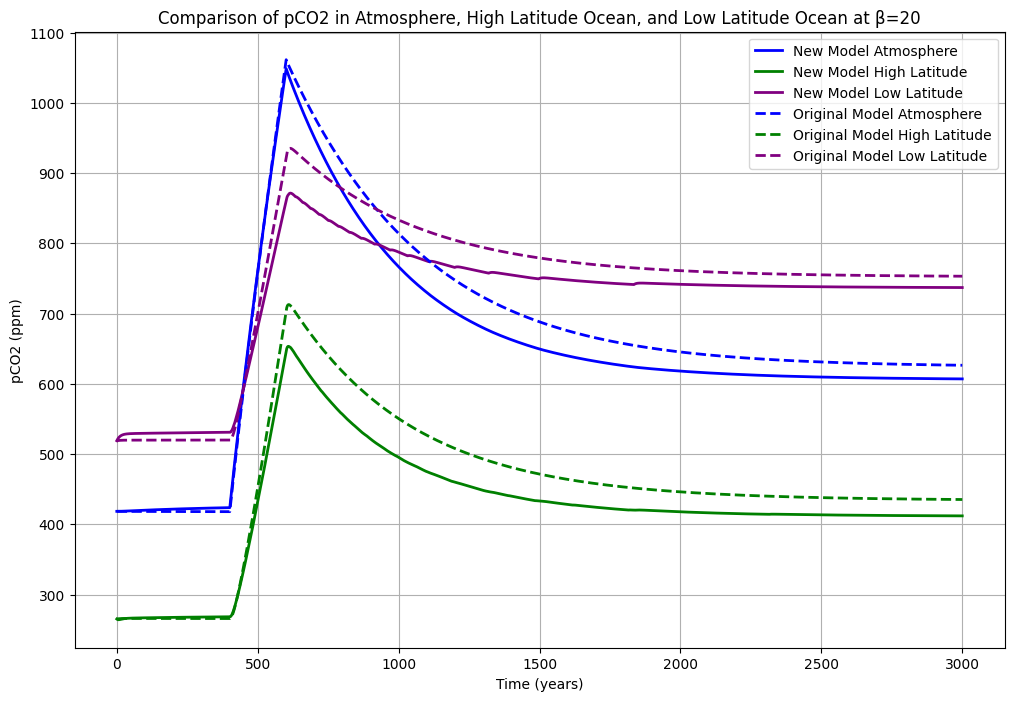

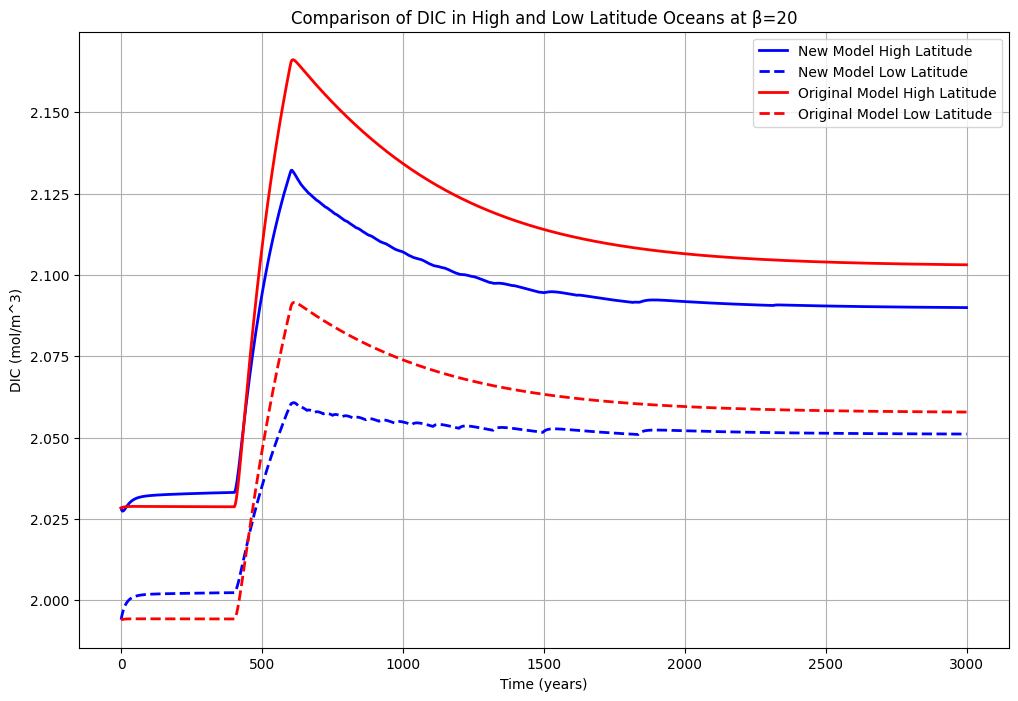

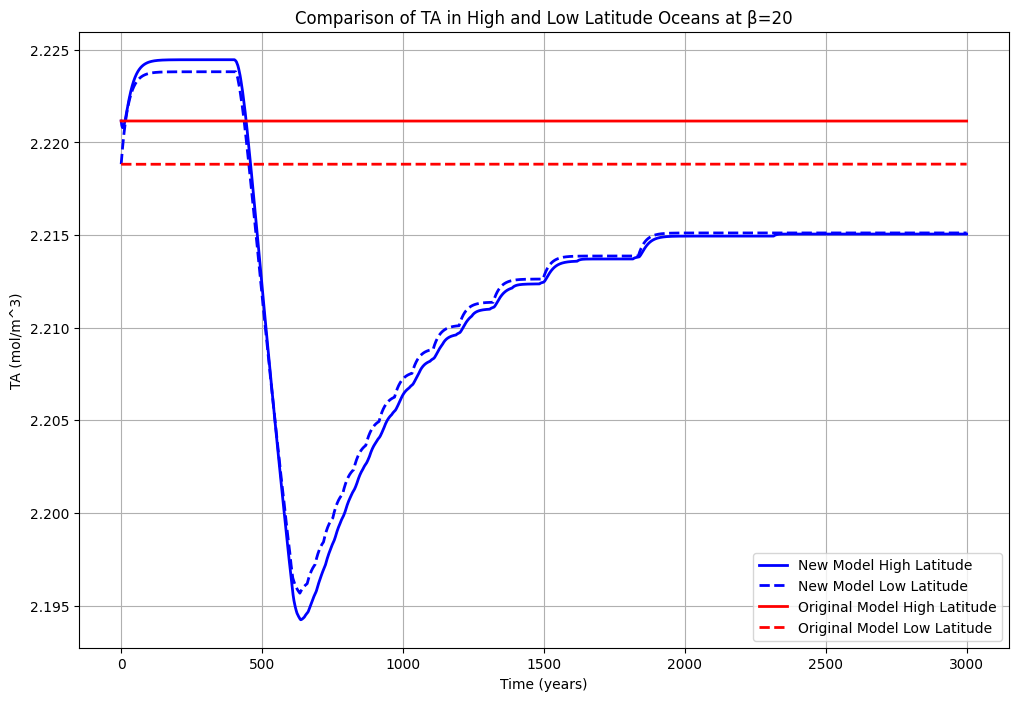

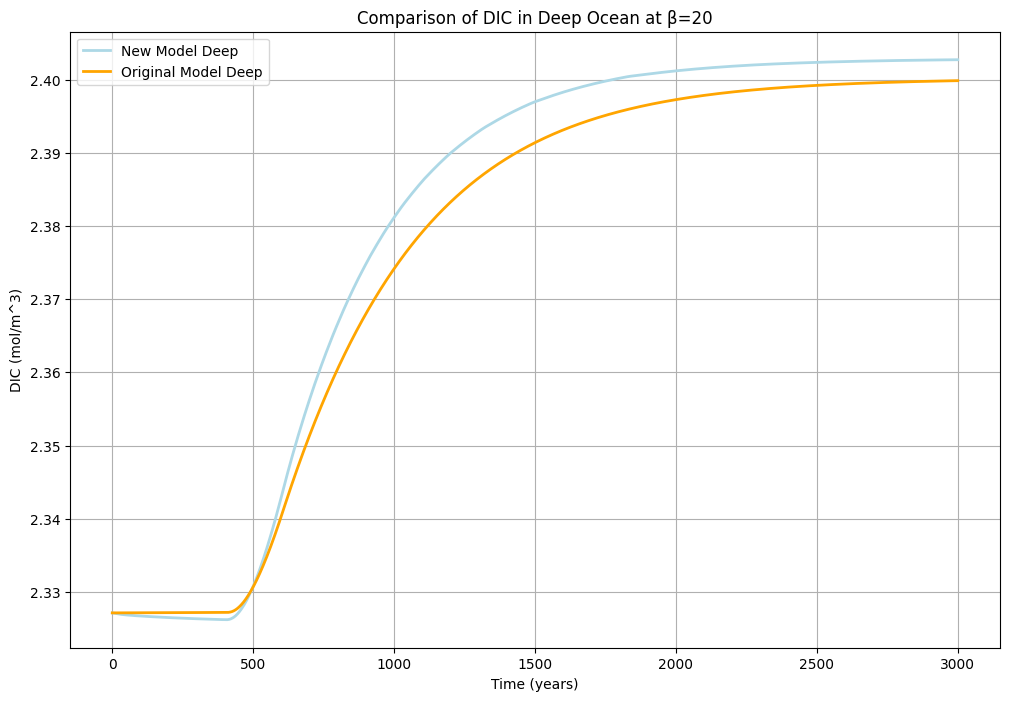

Original lolat pCO2: 753.2083, DIC:2.0579, TA: 2.2188 
Original hilat pCO2: 435.3867, DIC:2.1031, TA: 2.2212 
Original atmos pCO2: 626.4777
Experiment lolat pCO2: 737.0784, DIC:2.0511, TA: 2.2151 
Experiment hilat pCO2: 412.0898, DIC:2.0900, TA: 2.2151 
Experiment atmos pCO2: 607.0511


In [27]:
# Conduct your experiments here
#### EXPERIMENT 1:Set the  β  value to 20. Conduct a  CO2  release experiment, where  8 GtC yr−1  is emitted into the atmosphere for 200 years (between model years 400-600)
#### Run the model to steady-state, and examine the evolution of the carbon chemistry of the surface ocean and atmosphere compared to the original model.
#### Discuss the patterns you observe.
exp_lolat=init_lolat.copy()
exp_hilat=init_hilat.copy()
exp_deep=init_deep.copy()
exp_atmos=init_atmos.copy()
exp_lolat['beta_redfield']=20
exp_hilat['beta_redfield']=20
exp_atmos['GtC_emissions'] = np.zeros(time.shape)  # creat an array to hold the emission scenario
exp_atmos['GtC_emissions'][(time > 400) & (time <= 600)] = 8.0

#running experiment with original and edited model
time, ololat, ohilat, odeep, oatmos = ocean_model(init_lolat, init_hilat, init_deep, exp_atmos, 3000, 1)
time, exp1lolat, exp1hilat, exp1deep, exp1atmos = new_ocean_model(exp_lolat, exp_hilat, exp_deep, exp_atmos, 3000, 1)


# pCO2
plt.figure(figsize=(12, 8))
plt.plot(time, exp1atmos['pCO2'], label='New Model Atmosphere', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp1hilat['pCO2'], label='New Model High Latitude', color='green', linestyle='-', linewidth=2)
plt.plot(time, exp1lolat['pCO2'], label='New Model Low Latitude', color='purple', linestyle='-', linewidth=2)

plt.plot(time, oatmos['pCO2'], label='Original Model Atmosphere', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['pCO2'], label='Original Model High Latitude', color='green', linestyle='--', linewidth=2)
plt.plot(time, ololat['pCO2'], label='Original Model Low Latitude', color='purple', linestyle='--', linewidth=2)

plt.title('Comparison of pCO2 in Atmosphere, High Latitude Ocean, and Low Latitude Ocean at β=20')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for DIC
plt.figure(figsize=(12, 8))
plt.plot(time, exp1hilat['DIC'], label='New Model High Latitude', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp1lolat['DIC'], label='New Model Low Latitude', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['DIC'], label='Original Model High Latitude', color='red', linestyle='-', linewidth=2)
plt.plot(time, ololat['DIC'], label='Original Model Low Latitude', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of DIC in High and Low Latitude Oceans at β=20')
plt.xlabel('Time (years)')
plt.ylabel('DIC (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()

#TA
plt.figure(figsize=(12, 8))
plt.plot(time, exp1hilat['TA'], label='New Model High Latitude', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp1lolat['TA'], label='New Model Low Latitude', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['TA'], label='Original Model High Latitude', color='red', linestyle='-', linewidth=2)
plt.plot(time, ololat['TA'], label='Original Model Low Latitude', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of TA in High and Low Latitude Oceans at β=20')
plt.xlabel('Time (years)')
plt.ylabel('TA (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(time, exp1deep['DIC'], label='New Model Deep', color='lightblue', linewidth=2)
plt.plot(time, odeep['DIC'], label='Original Model Deep', color='orange', linewidth=2)
plt.title('Comparison of DIC in Deep Ocean at β=20')
plt.xlabel('Time (years)')
plt.ylabel('DIC (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()

#retrieving SS values
for k, v in get_last_values(ololat, ohilat, oatmos).items():
  if k == 'atmos':
    print(f"Original {k} pCO2: {v['pCO2']:.4f}")
  else:
    print(f"Original {k} pCO2: {v['pCO2']:.4f}, DIC:{v['DIC']:.4f}, TA: {v['TA']:.4f} ")

for k, v in get_last_values(exp1lolat, exp1hilat, exp1atmos).items():
  if k == 'atmos':
    print(f"Experiment {k} pCO2: {v['pCO2']:.4f}")
  else:
    print(f"Experiment {k} pCO2: {v['pCO2']:.4f}, DIC:{v['DIC']:.4f}, TA: {v['TA']:.4f} ")

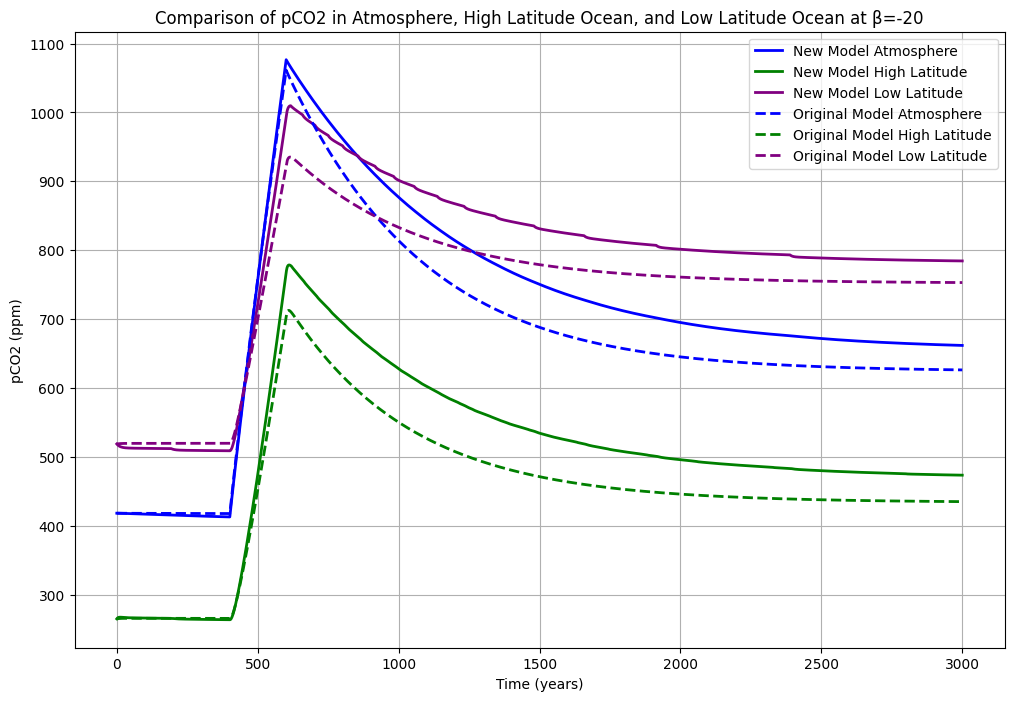

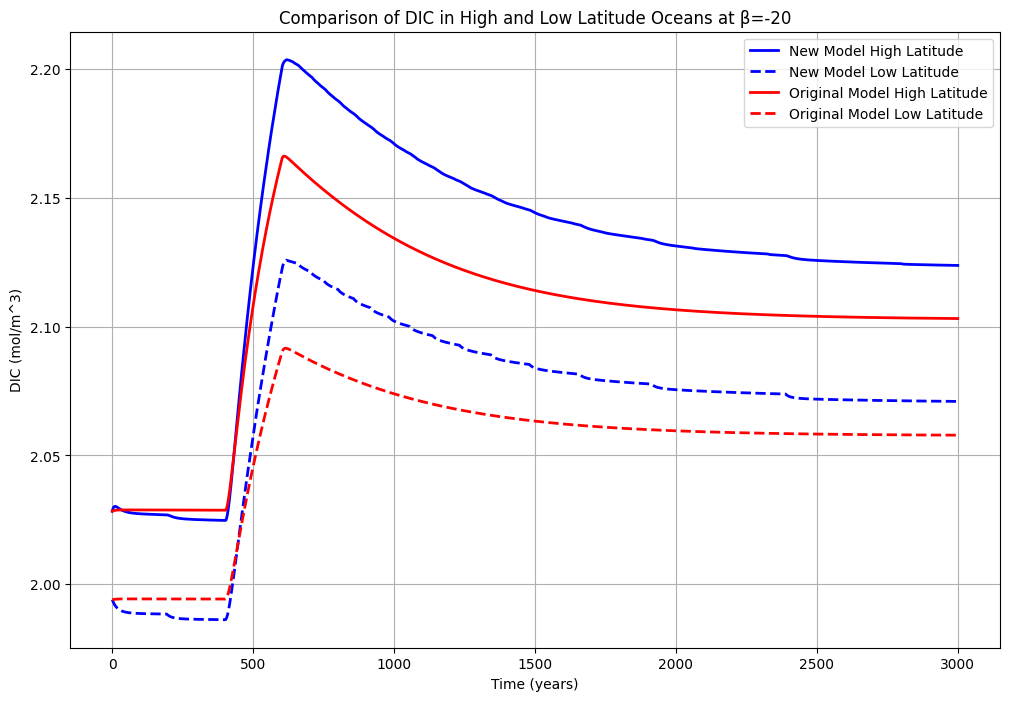

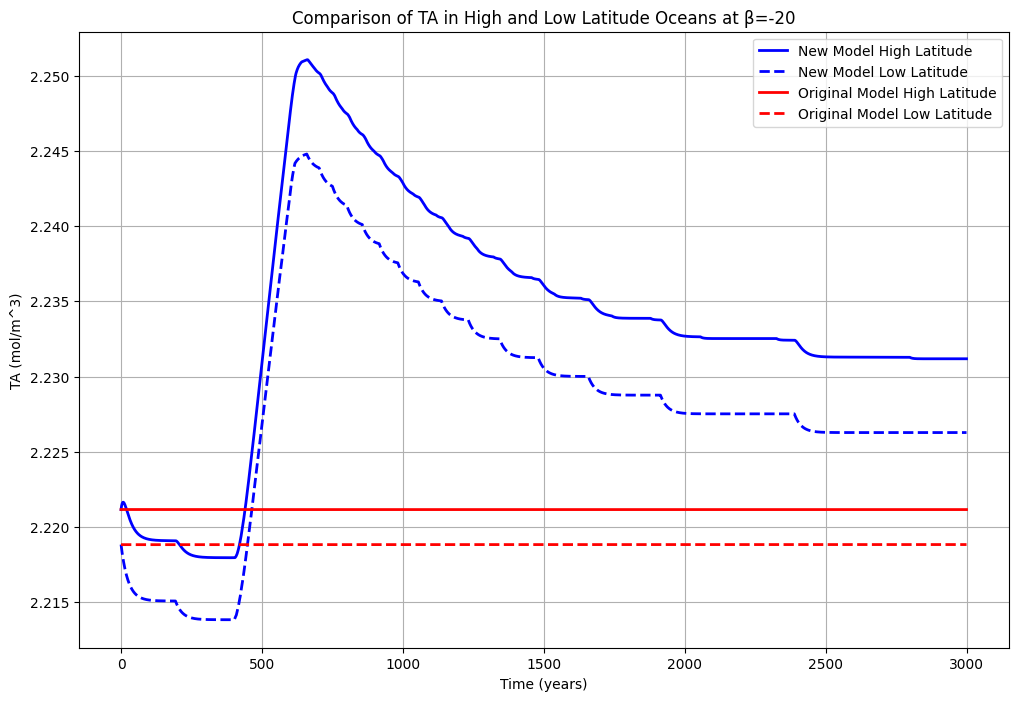

Original lolat pCO2: 753.2083, DIC:2.0579, TA: 2.2188 
Original hilat pCO2: 435.3867, DIC:2.1031, TA: 2.2212 
Original atmos pCO2: 626.4777
Experiment lolat pCO2: 784.5724, DIC:2.0710, TA: 2.2263 
Experiment hilat pCO2: 473.7703, DIC:2.1237, TA: 2.2312 
Experiment atmos pCO2: 661.9928


In [28]:
#### Expermient 2: Beta= -20
exp2_lolat=init_lolat.copy()
exp2_hilat=init_hilat.copy()
exp2_deep=init_deep.copy()
exp2_atmos=init_atmos.copy()
exp2_lolat['beta_redfield']= -20
exp2_hilat['beta_redfield']= -20
exp2_atmos['GtC_emissions'] = np.zeros(time.shape)  # creat an array to hold the emission scenario
exp2_atmos['GtC_emissions'][(time > 400) & (time <= 600)] = 8.0

time, ololat, ohilat, odeep, oatmos = ocean_model(init_lolat, init_hilat, init_deep, exp2_atmos, 3000, 1)
time, exp2lolat, exp2hilat, exp2deep, exp2atmos = new_ocean_model(exp2_lolat, exp2_hilat, exp2_deep, exp2_atmos, 3000, 1)

# pCO2
plt.figure(figsize=(12, 8))
plt.plot(time, exp2atmos['pCO2'], label='New Model Atmosphere', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp2hilat['pCO2'], label='New Model High Latitude', color='green', linestyle='-', linewidth=2)
plt.plot(time, exp2lolat['pCO2'], label='New Model Low Latitude', color='purple', linestyle='-', linewidth=2)

plt.plot(time, oatmos['pCO2'], label='Original Model Atmosphere', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['pCO2'], label='Original Model High Latitude', color='green', linestyle='--', linewidth=2)
plt.plot(time, ololat['pCO2'], label='Original Model Low Latitude', color='purple', linestyle='--', linewidth=2)

plt.title('Comparison of pCO2 in Atmosphere, High Latitude Ocean, and Low Latitude Ocean at β=-20')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for DIC
plt.figure(figsize=(12, 8))
plt.plot(time, exp2hilat['DIC'], label='New Model High Latitude', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp2lolat['DIC'], label='New Model Low Latitude', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['DIC'], label='Original Model High Latitude', color='red', linestyle='-', linewidth=2)
plt.plot(time, ololat['DIC'], label='Original Model Low Latitude', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of DIC in High and Low Latitude Oceans at β=-20')
plt.xlabel('Time (years)')
plt.ylabel('DIC (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()

#TA
plt.figure(figsize=(12, 8))
plt.plot(time, exp2hilat['TA'], label='New Model High Latitude', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp2lolat['TA'], label='New Model Low Latitude', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['TA'], label='Original Model High Latitude', color='red', linestyle='-', linewidth=2)
plt.plot(time, ololat['TA'], label='Original Model Low Latitude', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of TA in High and Low Latitude Oceans at β=-20')
plt.xlabel('Time (years)')
plt.ylabel('TA (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()


#retrieving SS values
for k, v in get_last_values(ololat, ohilat, oatmos).items():
  if k == 'atmos':
    print(f"Original {k} pCO2: {v['pCO2']:.4f}")
  else:
    print(f"Original {k} pCO2: {v['pCO2']:.4f}, DIC:{v['DIC']:.4f}, TA: {v['TA']:.4f} ")

for k, v in get_last_values(exp2lolat, exp2hilat, exp2atmos).items():
  if k == 'atmos':
    print(f"Experiment {k} pCO2: {v['pCO2']:.4f}")
  else:
    print(f"Experiment {k} pCO2: {v['pCO2']:.4f}, DIC:{v['DIC']:.4f}, TA: {v['TA']:.4f} ")


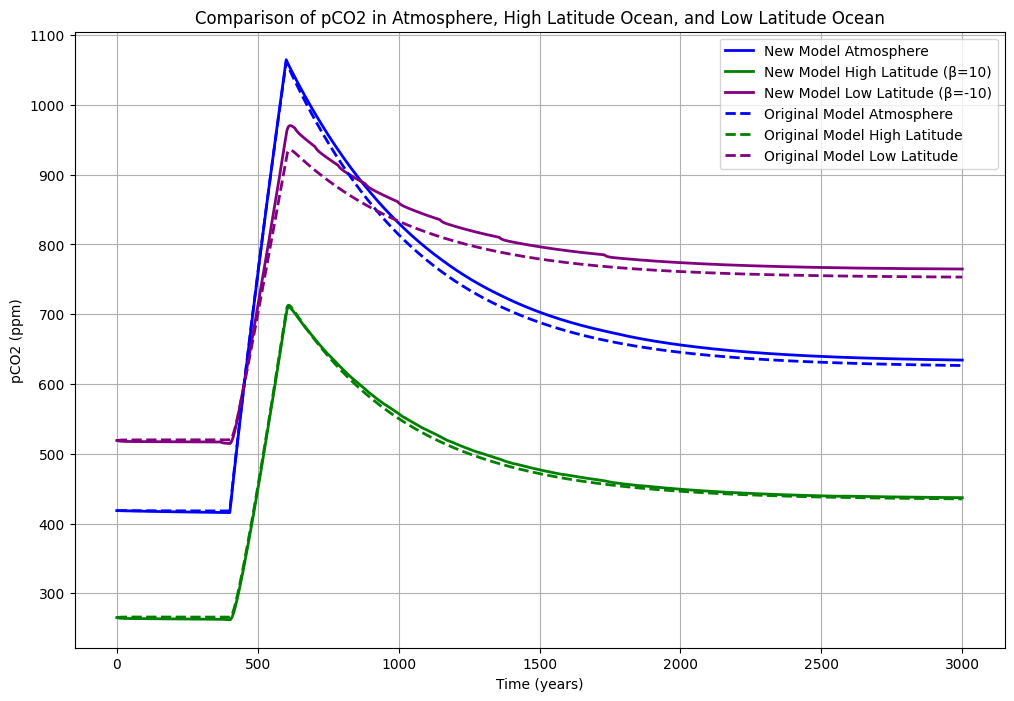

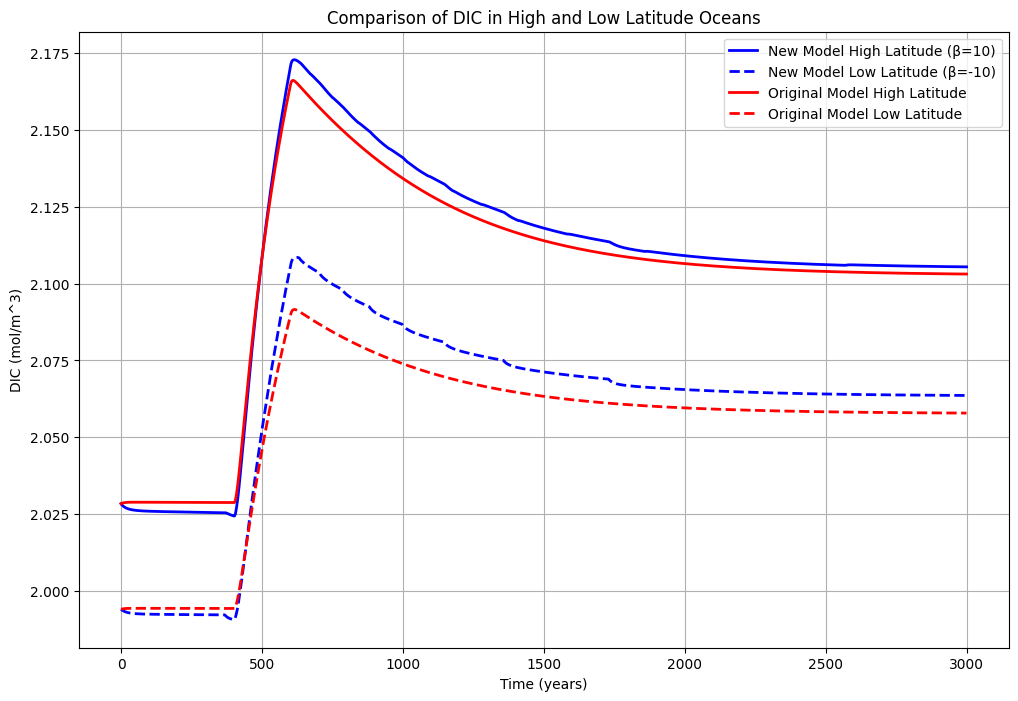

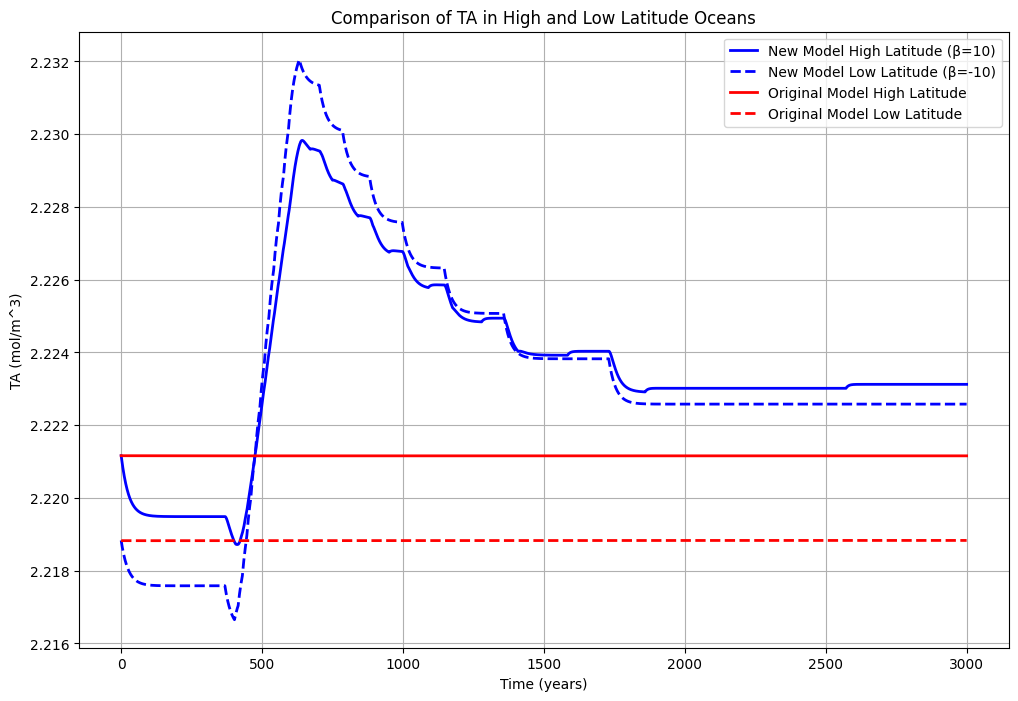

Original lolat pCO2: 753.2083, DIC:2.0579, TA: 2.2188 
Original hilat pCO2: 435.3867, DIC:2.1031, TA: 2.2212 
Original atmos pCO2: 626.4777
Experiment lolat pCO2: 764.7467, DIC:2.0636, TA: 2.2226 
Experiment hilat pCO2: 437.1531, DIC:2.1055, TA: 2.2231 
Experiment atmos pCO2: 634.2568


In [29]:
#### EXPERIMENT 3: B=10 HILAT, B=-10 LOLAT

exp3_lolat=init_lolat.copy()
exp3_hilat=init_hilat.copy()
exp3_deep=init_deep.copy()
exp3_atmos=init_atmos.copy()
exp3_lolat['beta_redfield']= -10
exp3_hilat['beta_redfield']=  10
exp3_atmos['GtC_emissions'] = np.zeros(time.shape)  # creat an array to hold the emission scenario
exp3_atmos['GtC_emissions'][(time > 400) & (time <= 600)] = 8.0

time, ololat, ohilat, odeep, oatmos = ocean_model(init_lolat, init_hilat, init_deep, exp2_atmos, 3000, 1)
time, exp3lolat, exp3hilat, exp3deep, exp3atmos = new_ocean_model(exp3_lolat, exp3_hilat, exp3_deep, exp3_atmos, 3000, 1)

# pCO2
plt.figure(figsize=(12, 8))
plt.plot(time, exp3atmos['pCO2'], label='New Model Atmosphere', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp3hilat['pCO2'], label='New Model High Latitude (β=10)', color='green', linestyle='-', linewidth=2)
plt.plot(time, exp3lolat['pCO2'], label='New Model Low Latitude (β=-10)', color='purple', linestyle='-', linewidth=2)

plt.plot(time, oatmos['pCO2'], label='Original Model Atmosphere', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['pCO2'], label='Original Model High Latitude', color='green', linestyle='--', linewidth=2)
plt.plot(time, ololat['pCO2'], label='Original Model Low Latitude', color='purple', linestyle='--', linewidth=2)

plt.title('Comparison of pCO2 in Atmosphere, High Latitude Ocean, and Low Latitude Ocean')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for DIC
plt.figure(figsize=(12, 8))
plt.plot(time, exp3hilat['DIC'], label='New Model High Latitude (β=10)', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp3lolat['DIC'], label='New Model Low Latitude (β=-10)', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['DIC'], label='Original Model High Latitude', color='red', linestyle='-', linewidth=2)
plt.plot(time, ololat['DIC'], label='Original Model Low Latitude', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of DIC in High and Low Latitude Oceans')
plt.xlabel('Time (years)')
plt.ylabel('DIC (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()

#TA
plt.figure(figsize=(12, 8))
plt.plot(time, exp3hilat['TA'], label='New Model High Latitude (β=10)', color='blue', linestyle='-', linewidth=2)
plt.plot(time, exp3lolat['TA'], label='New Model Low Latitude (β=-10)', color='blue', linestyle='--', linewidth=2)
plt.plot(time, ohilat['TA'], label='Original Model High Latitude', color='red', linestyle='-', linewidth=2)
plt.plot(time, ololat['TA'], label='Original Model Low Latitude', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of TA in High and Low Latitude Oceans')
plt.xlabel('Time (years)')
plt.ylabel('TA (mol/m^3)')
plt.legend()
plt.grid(True)
plt.show()


#retrieving SS values
for k, v in get_last_values(ololat, ohilat, oatmos).items():
  if k == 'atmos':
    print(f"Original {k} pCO2: {v['pCO2']:.4f}")
  else:
    print(f"Original {k} pCO2: {v['pCO2']:.4f}, DIC:{v['DIC']:.4f}, TA: {v['TA']:.4f} ")

for k, v in get_last_values(exp3lolat, exp3hilat, exp3atmos).items():
  if k == 'atmos':
    print(f"Experiment {k} pCO2: {v['pCO2']:.4f}")
  else:
    print(f"Experiment {k} pCO2: {v['pCO2']:.4f}, DIC:{v['DIC']:.4f}, TA: {v['TA']:.4f} ")